# Plot and calculate return period for wave height 

In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy import stats
import matplotlib.pylab as plt
from IPython.display import display, HTML
import pandas as pd
import csv

/Users/ryans/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Define set vars and filename

In [45]:
g = 9.81;
Dt = np.divide(11.9,12.) #Monthly
#Dt = 1
Cltresh = 0.05
extremeMarks = np.array(np.hstack((100, 50.,35., 30., 20, 10., 4., 2., 1.)))
filename = '/Users/ryans/Desktop/consulting/return_period/puerto_19.txt'

Import data from file

In [46]:
data = np.genfromtxt(filename, delimiter=",")
Hmo = data[:,1]

Initialize values

In [47]:
N = len(Hmo)
Fm = 1.-np.divide(np.arange(1., (N)+1), N+1.)
Trm = np.divide(Dt, (1 - Fm))

Hmo analyses 

In [48]:
Hmo = np.sort(Hmo)[::-1]
HmoMean = np.mean(Hmo)
HmoStdDev = np.std(Hmo)
Tp = 15.66*np.sqrt(np.divide(Hmo, g))

Ath = np.multiply(0.78, HmoStdDev)
Bth = HmoMean - np.multiply(0.45, HmoStdDev)

Gumbel linear curve fit and confidence hyperbolas

In [49]:
Pp = -np.log((-np.log(Fm))).conj().T
p = np.polyfit(Pp, Hmo, 1.)
Hmofit = np.polyval(p, Pp)
A = p[0]
B = p[1]

STC = np.sum(((Hmo-HmoMean)**2))
SCR = np.sum(((Hmo-Hmofit)**2))
R2 = 1. - np.divide(SCR, STC)

s2res = np.divide(SCR, (N-2.))
PpMean = np.mean(Pp)
SFp2 = np.sum((Pp - PpMean)**2.)
tstudent = stats.t.ppf((1.-Cltresh/2.), (N-2.))

dTyrs = (100 - np.multiply(Dt, 1.001))/9999
Tyrs = np.arange(100., (np.multiply(Dt, 1.001))+(-dTyrs), -dTyrs)
Fyrs = 1 - np.divide(Dt, Tyrs)
Fp = -np.log(-np.log(Fyrs)).conj().T

HmoTyrs = np.multiply(A,Fp) + B
Tpyrs = 15.66*np.sqrt(np.divide(HmoTyrs, g))

srescl = np.sqrt(np.dot(s2res, 1.+1./N+np.divide((Fp-PpMean)**2., SFp2)))
CLHmo_up = HmoTyrs+np.dot(srescl, tstudent)
CLHmo_down = HmoTyrs-np.multiply(srescl, tstudent)
#%  Lower CL of Hs
CLTp_up = 15.66*np.sqrt(np.divide(CLHmo_up, g))
CLTp_down = 15.66*np.sqrt(np.divide(CLHmo_down, g))

Plot figure

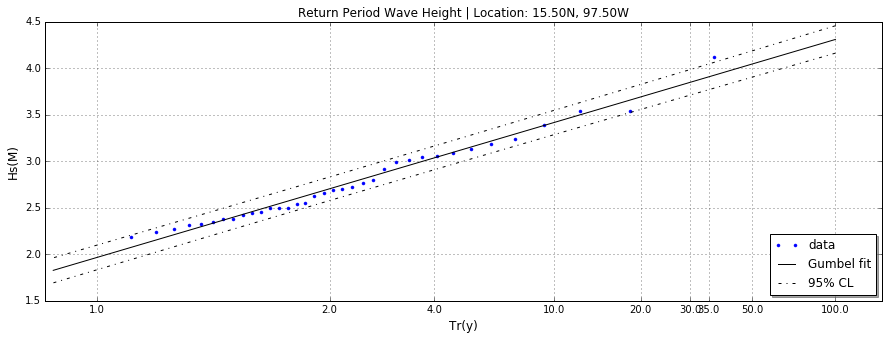

In [50]:
plt.figure(num=1, figsize=(15, 5))
plt.hold(True)
plt.plot(Pp, Hmo, 'b.', label="data")
gum = plt.plot(Fp, HmoTyrs, 'k-', label="Gumbel fit")
plt.plot(Fp,CLHmo_up, 'k-.', label="95% CL")
plt.plot(Fp,CLHmo_down, 'k-.')
legend = plt.legend(loc='lower right', shadow=True)

exceedFreq = 1 - np.divide(Dt,extremeMarks)
exceedFreqp = -np.log((-np.log(exceedFreq)))
plt.xticks(np.sort(exceedFreqp), np.sort(extremeMarks), fontsize=10)
plt.yticks(fontsize=10)
plt.grid()

plt.xlabel('Tr(y)', fontsize=12)
plt.ylabel('Hs(M)', fontsize=12)
plt.title('Return Period Wave Height | Location: 15.50N, 97.50W')
plt.hold(False)

Calculate extreme values 

In [51]:
Fext = 1 - np.divide(Dt, extremeMarks)
Fextp = -np.log((-np.log(Fext))).conj().T
Hmoext = np.dot(A, Fextp)+B
Tpext = 15.66*np.sqrt(np.divide(Hmoext, g))

# Tp values for data based on FDS assumption
sresext = np.sqrt(np.dot(s2res, 1.+1./N+np.divide((Fextp-PpMean)**2., SFp2)))
CLHmo_upext = Hmoext+np.dot(sresext, tstudent)
CLTp_upext = 15.66*np.sqrt(np.divide(CLHmo_upext, g))

Print Values 

In [52]:
filename = 'extremeinfo.txt'
fid = open(filename,'w')
outs = 'Tr(y),Hs(m),Tp(s),CL95-Hs(m),CL95-Tp(s)\n'
fid.write(outs)
for k in np.arange(1.,8.0):
    out = np.array(np.hstack((extremeMarks[int(k)-1],
    Hmoext[int(k)-1], Tpext[int(k)-1], CLHmo_upext[int(k)-1],
    CLTp_upext[int(k)-1])))
    output = ",".join(str(x) for x in out)
    print output
    fid.write(output)
    #print",".join(str(x) for x in out) 
fid.close()

100.0,4.31024502973,10.3802600535,4.45742337808,10.5559955213
50.0,4.04524955007,10.0561076352,4.18632136025,10.2299505838
35.0,3.90822435041,9.88432455543,4.04650199754,10.0576642477
30.0,3.8487954068,9.80888554129,3.98594368959,9.98212108287
20.0,3.69164884425,9.60654996199,3.82606321036,9.77987546033
10.0,3.41852215948,9.24435157125,3.5491108148,9.41926539949
4.0,3.03759665492,8.71409533546,3.16497687158,8.89492978903


Print Output in pandas dataframe 

In [12]:
dataframe = pd.read_csv('extremeinfo.txt')
display(dataframe)

,Tr(y),Hs(m),Tp(s),CL95-Hs(m),CL95-Tp(s)
0,100.0,4.310245,10.380260,4.457423,10.555996
1,50.0,4.045250,10.056108,4.186321,10.229951
2,30.0,3.848795,9.808886,3.985944,9.982121
3,10.0,3.418522,9.244352,3.549111,9.419265
4,5.0,3.133899,8.851151,3.261846,9.030026
5,2.0,2.704712,8.222763,2.831447,8.413204
6,1.0,1.966637,7.011635,2.099142,7.243996
